# import the required libraries


In [2]:
# Step 1: Import necessary libraries and the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# load the data

link colab with drive

In [3]:
file_path = 'boston.csv'
boston = pd.read_csv(file_path)

features = boston.drop(columns=['MEDV'])
prices = boston['MEDV']

# preprocessing the data

check for missings

In [4]:
missing_values = features.isnull().sum()
print('missing_values:')
print(missing_values)
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
else:
    print("There are missing values in the dataset.")

missing_values:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64
No missing values found in the dataset.


# box plot & histogram for all features


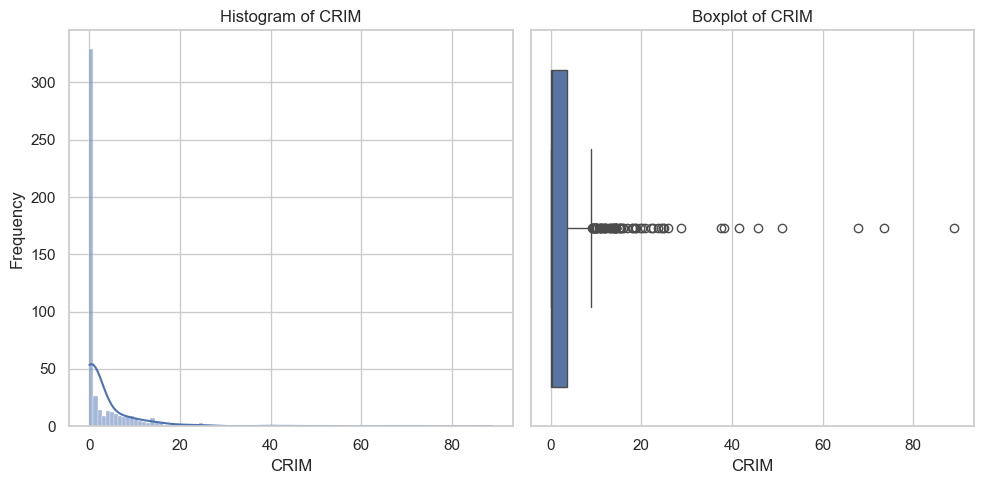

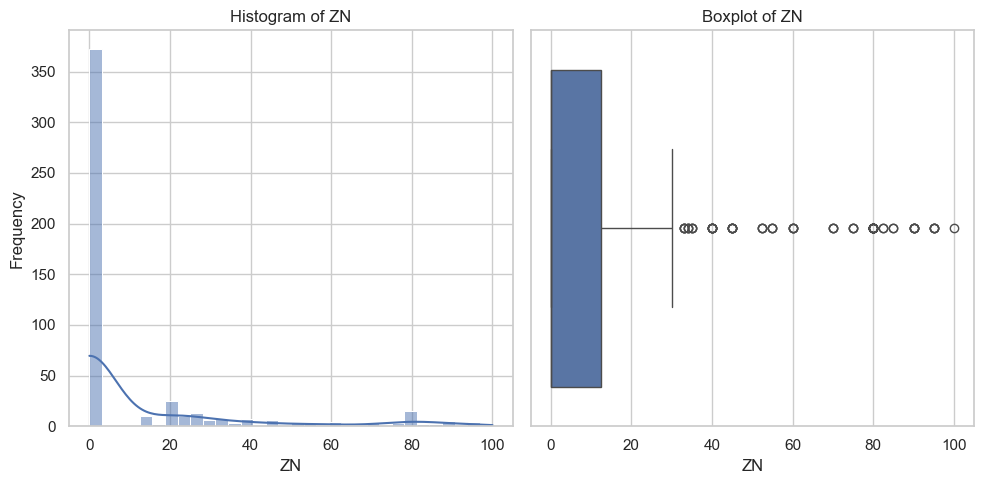

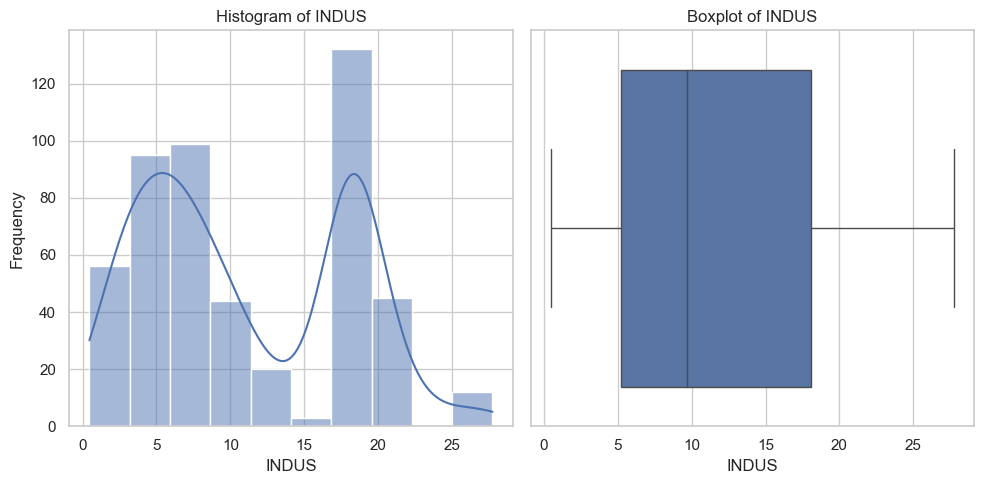

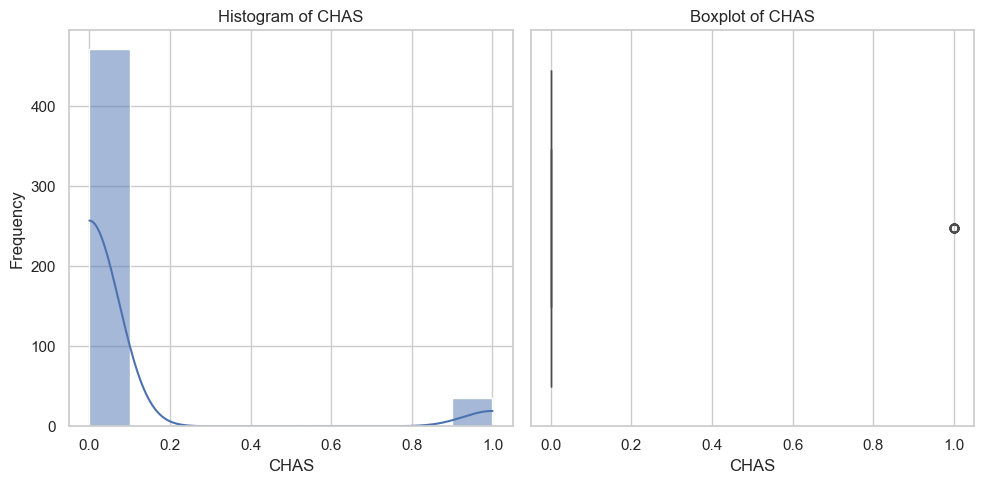

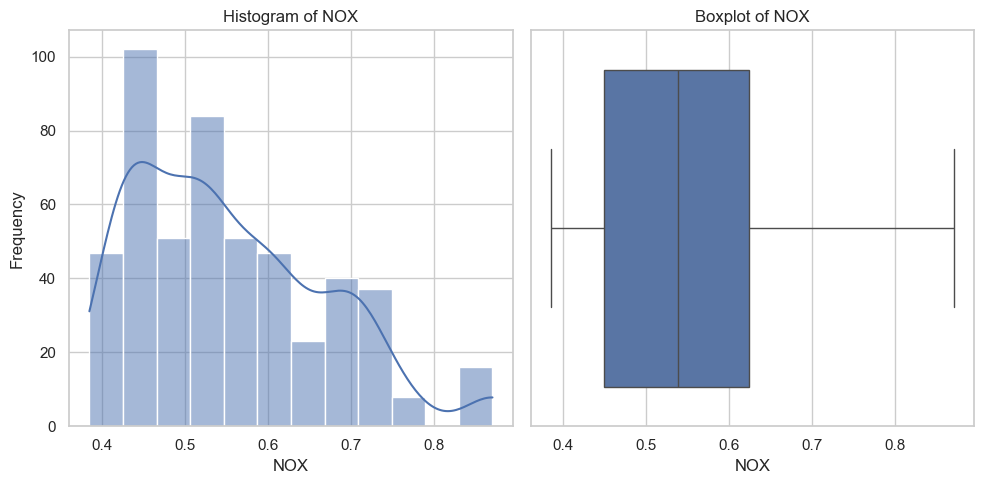

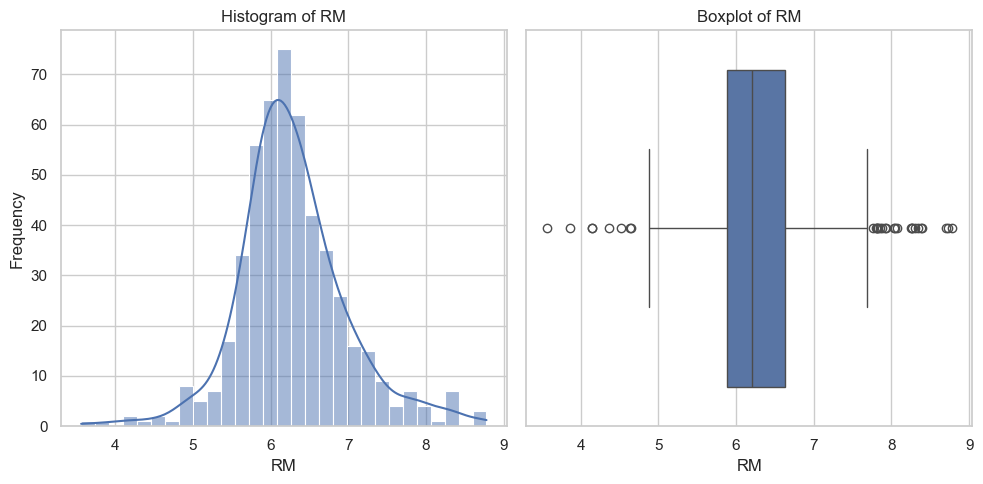

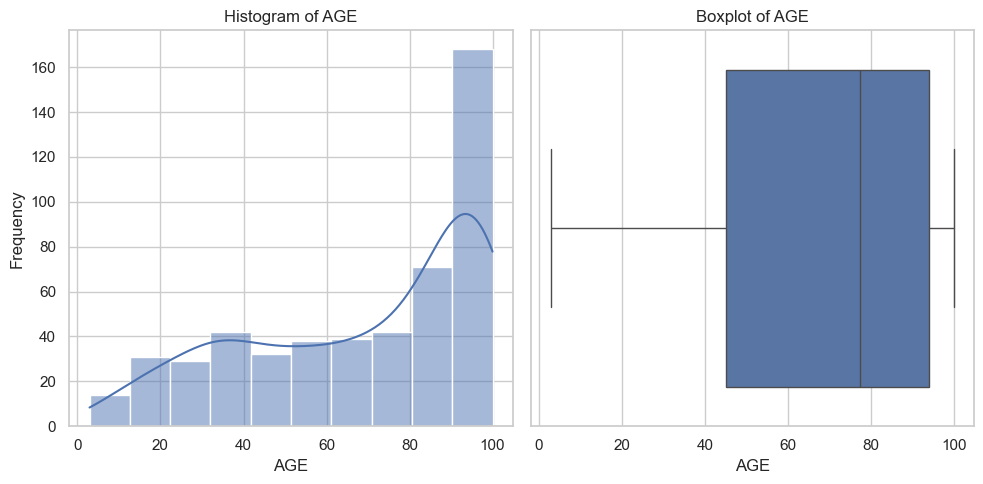

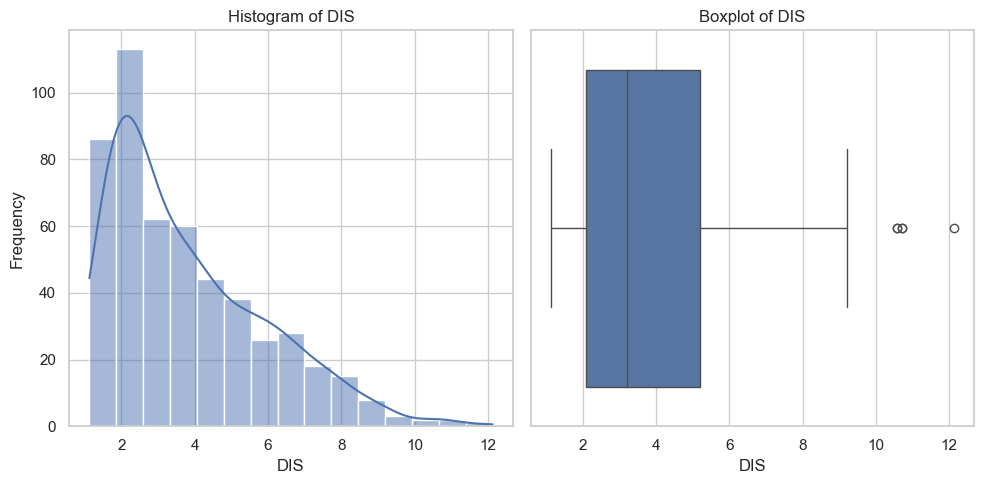

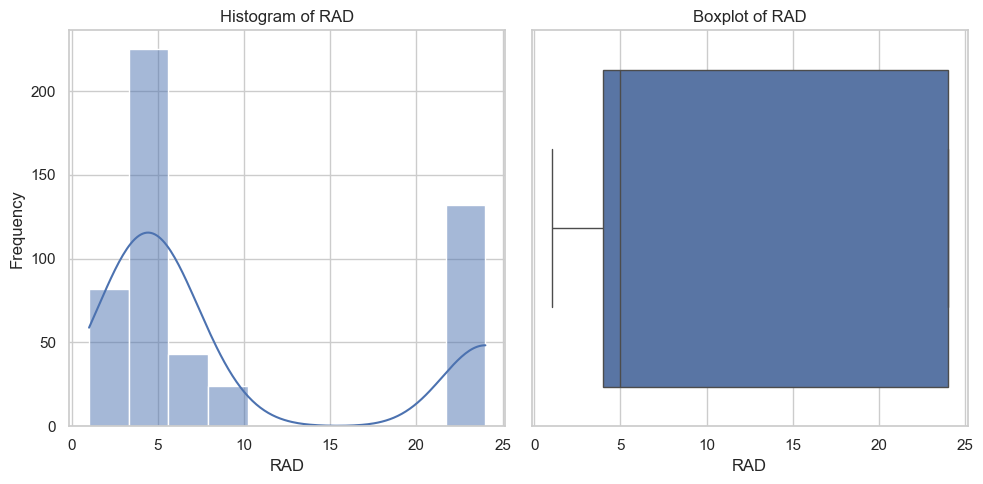

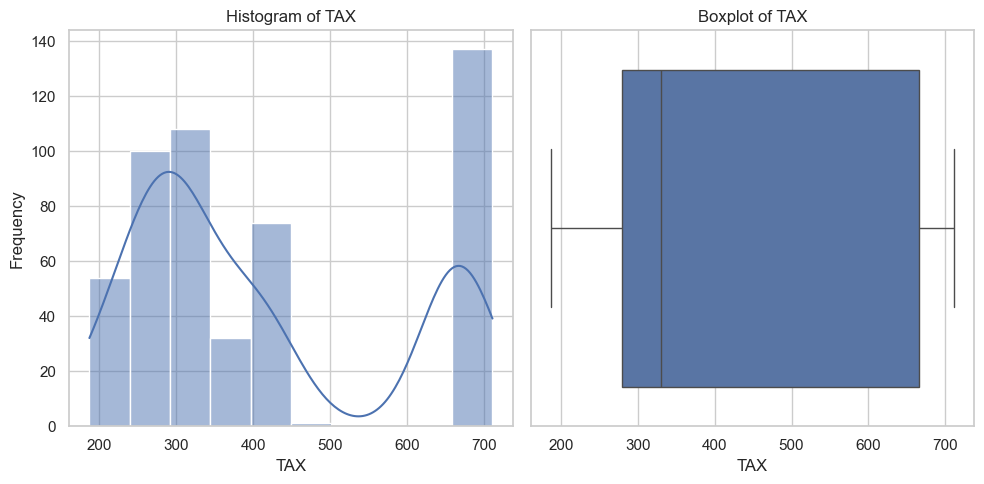

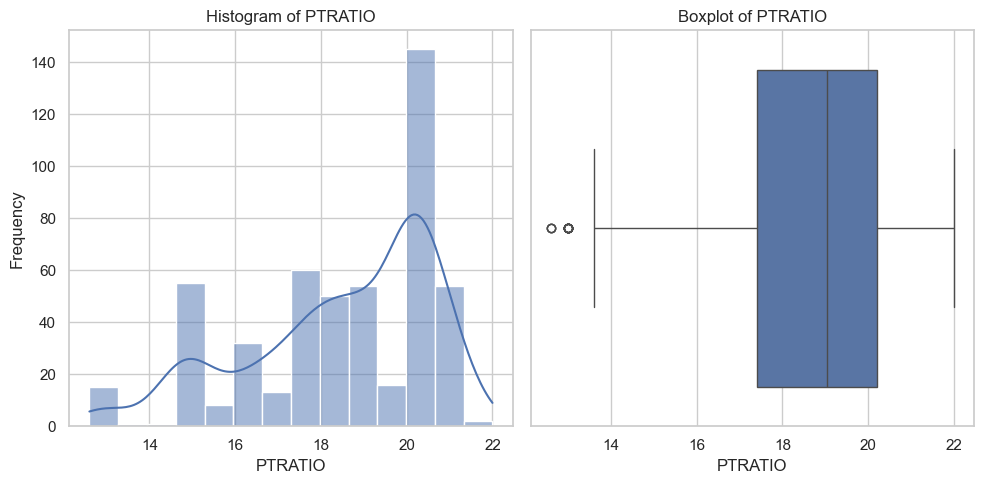

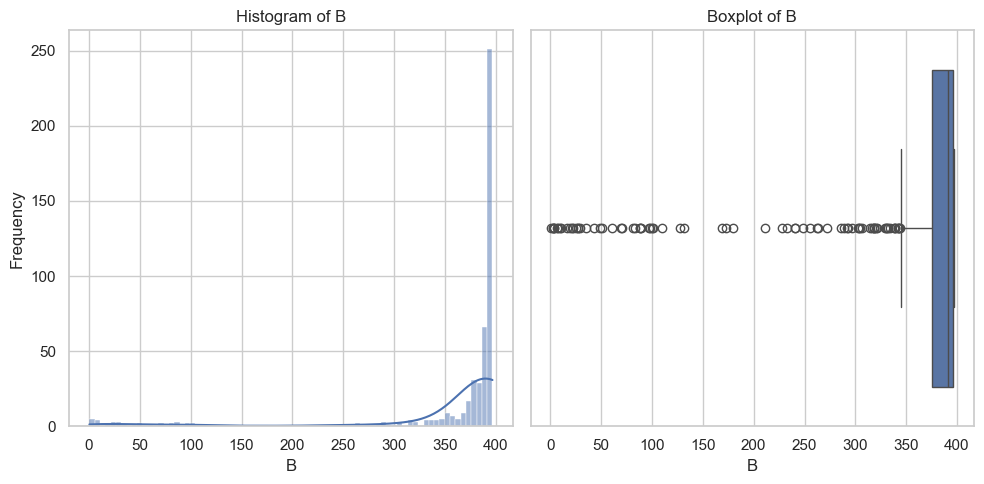

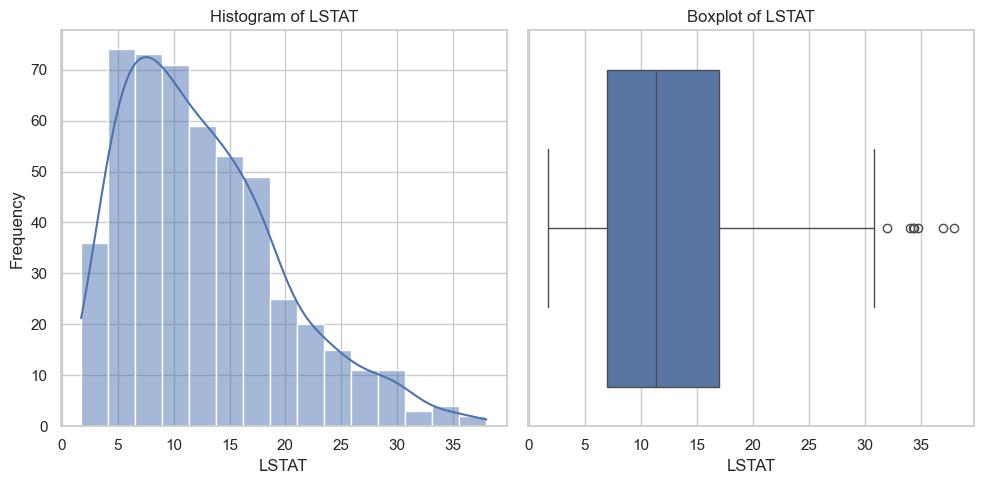

In [5]:
# plotting histogram & boxplot to chaeck for outliers visually

sns.set(style="whitegrid")

# Define the features to plot
features_to_plot = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# Plot histograms and boxplots for each feature
for feature in features_to_plot:
    plt.figure(figsize=(10, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=features, x=feature, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=features, x=feature)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

handling the outliers depending on the distribution

In [6]:
def handle_outliers(data):
    #for normal distribution like RM
    rm_mean = boston['RM'].mean()
    rm_std = boston['RM'].std()
    rm_lower_bound = rm_mean - 3 * rm_std
    rm_upper_bound = rm_mean + 3 * rm_std
    data = boston[(boston['RM'] >= rm_lower_bound) & (boston['RM'] <= rm_upper_bound)]

    #for skewed distribution
    skewed_features = ['CRIM', 'ZN', 'CHAS', 'DIS', 'B', 'LSTAT', 'AGE']
    for feature in skewed_features:
        q1 = boston[feature].quantile(0.25)
        q3 = boston[feature].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data = boston[(data[feature] >= lower_bound) & (boston[feature] <= upper_bound)]

    #for other distributions
    percentile_features = ['INDUS', 'NOX', 'RAD', 'TAX']
    for feature in percentile_features:
        lower_percentile = np.percentile(boston[feature], 1)
        upper_percentile = np.percentile(boston[feature], 99)
        data = boston[(data[feature] >= lower_percentile) & (boston[feature] <= upper_percentile)]

    return data
boston = handle_outliers(boston)

# split the data

In [7]:
# Split the data into training and testing sets (70-30 split)
features_train, features_test, prices_train, prices_test = train_test_split(features, prices, test_size=0.3, random_state=42)

scaling the features

In [8]:
# to standardize the range of independent variables or features in the dataset.
# improve the stability, convergence, and performance of machine learning algorithms
# making them more effective in capturing patterns and making accurate predictions.
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [9]:
'''# Feature engineering to find the most effective features to work with
correlation_matrix = np.abs(np.corrcoef(features_train_scaled.T, prices_train.T))
feature_correlation = correlation_matrix[-1, :-1]  # Extract correlations with the target variable

# Print correlations for every feature
print("Correlation of each feature with the target variable:")
for i, feature_name in enumerate(features.columns):
    print(f"{feature_name}: {feature_correlation[i]}")

selected_features = np.where(feature_correlation >= 0.49)[0]   # Select features with correlation >= 0.5

# Use only the selected features
features_train_selected = features_train_scaled[:, selected_features]
features_test_selected = features_test_scaled[:, selected_features]

# Print the number of selected features and their names
print("Number of selected features:", len(selected_features))
print("Selected features:")
for feature_index in selected_features:
    print(features.columns[feature_index])
print("Number of selected features:", len(selected_features))
'''

'# Feature engineering to find the most effective features to work with\ncorrelation_matrix = np.abs(np.corrcoef(features_train_scaled.T, prices_train.T))\nfeature_correlation = correlation_matrix[-1, :-1]  # Extract correlations with the target variable\n\n# Print correlations for every feature\nprint("Correlation of each feature with the target variable:")\nfor i, feature_name in enumerate(features.columns):\n    print(f"{feature_name}: {feature_correlation[i]}")\n\nselected_features = np.where(feature_correlation >= 0.49)[0]   # Select features with correlation >= 0.5\n\n# Use only the selected features\nfeatures_train_selected = features_train_scaled[:, selected_features]\nfeatures_test_selected = features_test_scaled[:, selected_features]\n\n# Print the number of selected features and their names\nprint("Number of selected features:", len(selected_features))\nprint("Selected features:")\nfor feature_index in selected_features:\n    print(features.columns[feature_index])\nprint("Nu

# using REF for feature selection

In [10]:
# Iteratively remove the least significant features based on model performance
# until the desired number of features is reached.
# Define the estimator (Random Forest in this case)
estimator = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize RFE
rfe = RFE(estimator, n_features_to_select=5)  # Select the top 5 features

# Fit RFE to data
rfe.fit(features_train_scaled, prices_train)

# Get selected features
selected_features = rfe.get_support(indices=True)
# Print selected feature names
print("Selected features:")
for feature_index in selected_features:
    print(features.columns[feature_index])

# the selected features are used to create featuresto train and test
features_test_selected = features_test_scaled[:, selected_features]
features_train_selected = features_train_scaled[:, selected_features]

Selected features:
CRIM
RM
DIS
PTRATIO
LSTAT


# SVR model

build and train the svr model

In [11]:
# define support vector regression as the regressor
svr = SVR()
cv_scores=[]
#apply grid search for finding best parameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf'],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}
# calling the grid search and fit it to the features
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(features_train_selected, prices_train.values.ravel())

# printing the best parameter Best parameters
print("Best Parameters:", grid_search.best_params_)

# using the KFold method
n_splits = 5 # NO.folds

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

######Note#######
# a fold refers to a subset of the dataset that is used for training and validation.
# an epoch refers to one complete pass through the entire training dataset. but here through a fold!

# iterating over each epoch in a fold
for fold_idx, (train_index, val_index) in enumerate(kf.split(features_train_selected)):
    print(f"Fold {fold_idx + 1}/{n_splits}")

    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = features_train_selected[train_index], features_train_selected[val_index]
    y_train_fold, y_val_fold = prices_train.values[train_index], prices_train.values[val_index]

    # Train SVR model within this fold
    svr.fit(X_train_fold, y_train_fold)
    n_epochs = 8
    # Evaluate SVR model accuracy for every epoch
    for epoch in range(n_epochs):
        # Perform predictions for validation data
        y_val_pred = svr.predict(X_val_fold)

        # Calculate accuracy for this epoch
        accuracy = r2_score(y_val_fold, y_val_pred)

        # Print accuracy for this epoch
        print(f"Epoch {epoch + 1} - Test Accuracy: {accuracy}")

Best Parameters: {'C': 100, 'epsilon': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
Fold 1/5
Epoch 1 - Test Accuracy: 0.46376805650246133
Epoch 2 - Test Accuracy: 0.46376805650246133
Epoch 3 - Test Accuracy: 0.46376805650246133
Epoch 4 - Test Accuracy: 0.46376805650246133
Epoch 5 - Test Accuracy: 0.46376805650246133
Epoch 6 - Test Accuracy: 0.46376805650246133
Epoch 7 - Test Accuracy: 0.46376805650246133
Epoch 8 - Test Accuracy: 0.46376805650246133
Fold 2/5
Epoch 1 - Test Accuracy: 0.6015704953326717
Epoch 2 - Test Accuracy: 0.6015704953326717
Epoch 3 - Test Accuracy: 0.6015704953326717
Epoch 4 - Test Accuracy: 0.6015704953326717
Epoch 5 - Test Accuracy: 0.6015704953326717
Epoch 6 - Test Accuracy: 0.6015704953326717
Epoch 7 - Test Accuracy: 0.6015704953326717
Epoch 8 - Test Accuracy: 0.6015704953326717
Fold 3/5
Epoch 1 - Test Accuracy: 0.7123078210209974
Epoch 2 - Test Accuracy: 0.7123078210209974
Epoch 3 - Test Accuracy: 0.7123078210209974
Epoch 4 - Test Accuracy: 0.7123078210209974
Epoch 5 - 

In [12]:
# calculating some cross validation scores
val_score = svr.score(X_val_fold, y_val_fold)
cv_scores.append(val_score)  # Append the validation score to cv_scores

print(f"Validation R^2 Score - Fold {fold_idx + 1}: {val_score}")

# Print cross-validation scores
print("Cross Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))


Validation R^2 Score - Fold 5: 0.8108895101392032
Cross Validation Scores: [0.8108895101392032]
Mean CV Score: 0.8108895101392032


In [13]:
#Evaluate the model
prices_pred = grid_search.predict(features_test_selected)

#mse: measures the average squared difference between the actual and predicted values.
mse = mean_squared_error(prices_test, prices_pred)

#R-squared: represents the proportion of the variance in the dependent variable that is predictable from the independent variables.
r2 = r2_score(prices_test, prices_pred)

#print the testing error measurments
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 12.919227305210606
R-squared: 0.8266180299348362


In [14]:
# Check for overfitting
# calculate the score for training and testing to check for overfitting
train_score = grid_search.score(features_train_selected, prices_train)
test_score = grid_search.score(features_test_selected, prices_test)

# printing the score for those togehter
print("Training Score:", train_score)
print("Testing Score:", test_score)

Training Score: 0.9053992307446797
Testing Score: 0.8266180299348362


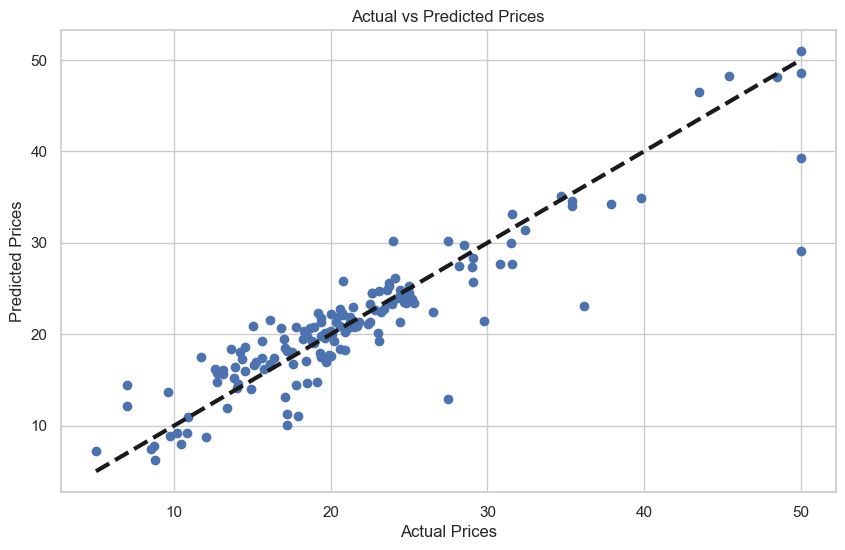

In [15]:
# Step 10: Plotting (Dataset and Predictions)
plt.figure(figsize=(10, 6))

# Plotting actual vs predicted prices
plt.scatter(prices_test, prices_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")

# Plotting the identity line
plt.plot([prices_test.min(), prices_test.max()], [prices_test.min(), prices_test.max()], 'k--', lw=3)
plt.show()

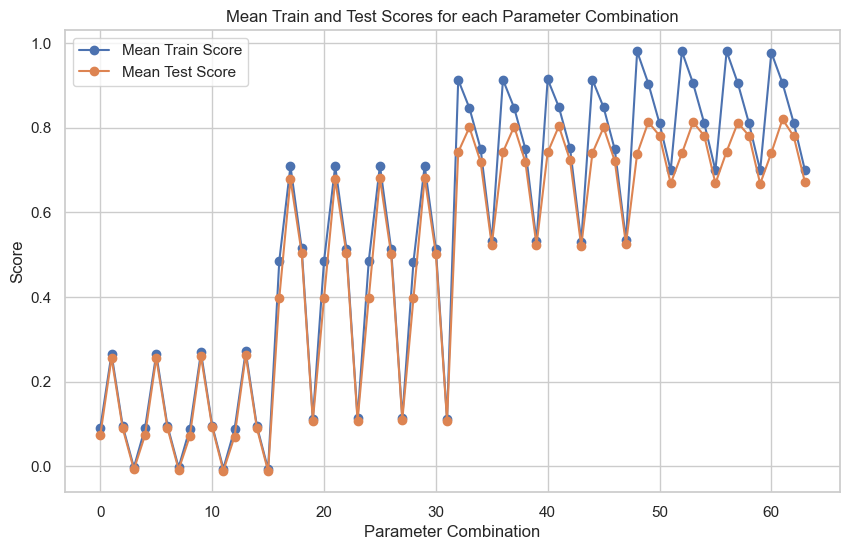

In [16]:
# Extract the mean train and test scores from the GridSearchCV results
mean_train_scores = grid_search.cv_results_['mean_train_score']
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Plot the mean train and test scores for each parameter combination
plt.figure(figsize=(10, 6))
plt.plot(mean_train_scores, label='Mean Train Score', marker='o')
plt.plot(mean_test_scores, label='Mean Test Score', marker='o')
plt.xlabel('Parameter Combination')
plt.ylabel('Score')
plt.title('Mean Train and Test Scores for each Parameter Combination')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
import tkinter as tk
from tkinter import messagebox

def predict_price():
    user_input = []
    for feature_name in features.columns:
        value = float(entry_vars[feature_name].get())
        user_input.append(value)

    user_input_array = np.array(user_input).reshape(1, -1)
    user_input_scaled = scaler.transform(user_input_array)
    user_input_selected = user_input_scaled[:, selected_features]
    predicted_price = grid_search.predict(user_input_selected)

    messagebox.showinfo("Predicted Price", f"The predicted price is: {predicted_price[0]}")

#Create GUI window
root = tk.Tk()
root.title("House Price Prediction")

#Create entry fields for user input
entry_vars = {}
for i, feature_name in enumerate(features.columns):
    label = tk.Label(root, text=feature_name)
    label.grid(row=i, column=0, padx=10, pady=5)

    entry_var = tk.StringVar()
    entry = tk.Entry(root, textvariable=entry_var)
    entry.grid(row=i, column=1, padx=10, pady=5)

    entry_vars[feature_name] = entry_var

#Create predict button
predict_button = tk.Button(root, text="Predict", command=predict_price)
predict_button.grid(row=len(features.columns), columnspan=2, padx=10, pady=10)

root.mainloop()